# Capstone Project – The Battle of neighborhoods (Week1)

## A description of the problem and a discussion of the background.

##### 1 - Description of the problem: 

People starting new businesses have different requirements and studies to conduct before launching their project. To start a restaurant, people need to find the right place. The definition of right place incorporate different aspects; places with high people density, not flooded with restaurant, and including other facilities that might lead people to think about food. For instance, malls, schools and companies incorporate people doing different activities, yet, all might need to have a meal at a certain point of their day. Doing, the proper research might help the business owner locate contender boroughs in a city where the busines will have much more chances to succeed.

##### 2- Business understanding: 

Given the reality of the targeted business and its success requirements, Can we provide a short list of boroughs to help business owner decide where to start its business?

##### 3 - Interested people: 

This problem is very interesting for all the people deciding to start their own restaurant. This approach can be also adopted for other kind of business like gyms and entertainment services.


## A description of the data and how it will be used to solve the problem

##### Data is the most important element of any data science project, almost 60% of relevancy of any machine learning model is related to the relevancy of the dataset and the different features it incorporates.

###### For our use case, the data needed can be summarized as follow: 

1-	For a targeted city, The boroughs and neighborhoods and their corresponding locations.

2-	List of schools and companies for each borough and neighborhood.

3-	List of entertainment venues for each borough and neighbors (Malls, Gyms, gaming rooms …)

4-	List of restaurants for each borough and neighborhood

Assuming the guy is willing to open a restaurant in Toronto, we will scrape the data of postal codes of the city of Toronto and get the location of the different boroughs, for each we will use the foursquare to explore the location and get different venues in it. Later, we will filter the venues to extract those that will help us in our analysis such as restaurants, stations, malls and other entertainment facilities that usually attract people.

Processing this data, will help us identify subset of boroughs where we have the most of facilities that might lead people to go and eat, this also should be tempered by the number of restaurant in the borough so that you don’t open your business in a place already crowded with restaurants.

###### Data sources: 
1 - Toronto PostCOde: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

2 - Foursquare API

###### Data usage steps:
1 - Location of the targeted city and visualize using map and folium 

2 - Beautifulsoup and scrap data related to borough and neighboros of the atrgeted city 

3 - use open dataset to fetch the location of each neighbor 

4 - Foursquare to explore each neighbor 

5 - extract usefull venues in neighbor e.g., restourants, hotels, gyms, parks, stores 

6 - aggregate venues by neighbors and derive scores to highlight the relevancy of the neighbor 

7 - derive subset of neighbors per borough with the highest prospects


###### report table of content


###### Introduction Section : 
    
    ⁃ Discussion of the business problem and the interested audience in this project.
    
###### Data Section: 
    
    ⁃ Description of the data that will be used to solve the problem and the sources.
    
###### Methodology section: 

    ⁃ Discussion and description of exploratory data analysis 

###### Results section:

    ⁃ Discussion of the results.
    
###### Discussion section:

    ⁃ Elaboration and discussion on any observations noted 
    
###### Conclusion section:
    
    ⁃ Report Conclusion.



In [1]:
import numpy as np 
import pandas as pd
import bs4
import requests
#!pip install geocoder
#import geocoder 
!conda install -c conda-forge folium=0.5.0 --yes
import folium
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors


Solving environment: done

# All requested packages already installed.



In [3]:
#Toronto coordinates we can get them online directly
latitude=43.653226
longitude=-79.3831843
venues_map = folium.Map(location=[latitude, longitude], zoom_start=13) # generate map centred around the Conrad Hotel
venues_map

### Its time to get postcode, boroughs and neighbors from the targeted city - selected by the bussiness owner

In [4]:
#lets assign the url to the wiki page and insatntiate a beautifulsoup object with the get request output
url ='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
toronto_wiki = requests.get(url).text
soup_object_toronto=bs4.BeautifulSoup(toronto_wiki,'lxml')
#first we locate the table 
table=soup_object_toronto.find('table')

### We process the table and extract only the three variables we want, we also clean the data

In [5]:
Toronto_post_bor_neigh = []
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
    Toronto_post_bor_neigh.append(cell)
#we creata dataframe from the extracted nisted list
df=pd.DataFrame(Toronto_post_bor_neigh)
#preprocessing
df1 = df[df.Borough != 'Not assigned']
df2 = df1.groupby(['PostalCode','Borough'], sort=False).agg(', '.join)
df2.reset_index(inplace=True)

df2['Neighborhood'] = np.where(df2['Neighborhood'] == 'Not assigned',df2['Borough'], df2['Neighborhood'])
df2.head(10)

PostalCode           Borough                      Neighborhood
0        M3A        North York                         Parkwoods
1        M4A        North York                  Victoria Village
2        M5A  Downtown Toronto         Regent Park, Harbourfront
3        M6A        North York  Lawrence Manor, Lawrence Heights
4        M7A      Queen's Park     Ontario Provincial Government
5        M9A         Etobicoke                  Islington Avenue
6        M1B       Scarborough                    Malvern, Rouge
7        M3B        North York                   Don Mills North
8        M4B         East York   Parkview Hill, Woodbine Gardens
9        M5B  Downtown Toronto          Garden District, Ryerson

### We need the location of every neighbor, we use an open dataset 

In [6]:
######## use the csv file 
#load the csv in daatframe
la_lo_csv = pd.read_csv('https://cocl.us/Geospatial_data')

# now lets match the postal Code with the PostcodeID and get a merged dataframe
df_lo_la_toronto = pd.merge(df2, la_lo_csv, left_on='PostalCode', right_on='Postal Code')
df_lo_la_toronto.head(10)
#lets drop the Post code its just duplicated 
df_lo_la_toronto=df_lo_la_toronto.drop('Postal Code',axis=1)
df_lo_la_toronto.head(10)

PostalCode           Borough                      Neighborhood   Latitude  \
0        M3A        North York                         Parkwoods  43.753259   
1        M4A        North York                  Victoria Village  43.725882   
2        M5A  Downtown Toronto         Regent Park, Harbourfront  43.654260   
3        M6A        North York  Lawrence Manor, Lawrence Heights  43.718518   
4        M7A      Queen's Park     Ontario Provincial Government  43.662301   
5        M9A         Etobicoke                  Islington Avenue  43.667856   
6        M1B       Scarborough                    Malvern, Rouge  43.806686   
7        M3B        North York                   Don Mills North  43.745906   
8        M4B         East York   Parkview Hill, Woodbine Gardens  43.706397   
9        M5B  Downtown Toronto          Garden District, Ryerson  43.657162   

   Longitude  
0 -79.329656  
1 -79.315572  
2 -79.360636  
3 -79.464763  
4 -79.389494  
5 -79.532242  
6 -79.194353  
7 -79.352188  
8 -79.309937  
9 -79.378937

### We use credential to connect to the foursquare api and explore the different venues in each neighbor 

In [7]:
CLIENT_ID = 'TJI0OMJ0INFZVVD1SQBTJQTYXWKYBJXG4J4OD4WPGPOUKA4P' # your Foursquare ID
CLIENT_SECRET = '1QLSVKLKZDOVWZCY2LUMNNTFJKOMONH2ZP334AVRHT4XE1IA' # your Foursquare Secret
ACCESS_TOKEN = 'VENHRI5EXTAK5QFACKIRNJOCK5LRXTV0RXS2UGKCJAEZBIQ0' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: TJI0OMJ0INFZVVD1SQBTJQTYXWKYBJXG4J4OD4WPGPOUKA4P
CLIENT_SECRET:1QLSVKLKZDOVWZCY2LUMNNTFJKOMONH2ZP334AVRHT4XE1IA


In [9]:
#get venues for each neighborhood
def getNearbyVenues(borou,names, latitudes, longitudes, radius):
    
    venues_list=[]
    for borog, name, lat, lng in zip(borou,names, latitudes, longitudes):
        print(borog,name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            borog,
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough','Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [10]:
df_toronto_venues = getNearbyVenues(df_lo_la_toronto.Borough, df_lo_la_toronto.Neighborhood, df_lo_la_toronto.Latitude,df_lo_la_toronto.Longitude, 1000)

North York Parkwoods
North York Victoria Village
Downtown Toronto Regent Park, Harbourfront
North York Lawrence Manor, Lawrence Heights
Queen's Park Ontario Provincial Government
Etobicoke Islington Avenue
Scarborough Malvern, Rouge
North York Don Mills North
East York Parkview Hill, Woodbine Gardens
Downtown Toronto Garden District, Ryerson
North York Glencairn
Etobicoke West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Scarborough Rouge Hill, Port Union, Highland Creek
North York Don Mills South
East York Woodbine Heights
Downtown Toronto St. James Town
York Humewood-Cedarvale
Etobicoke Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Scarborough Guildwood, Morningside, West Hill
East Toronto The Beaches
Downtown Toronto Berczy Park
York Caledonia-Fairbanks
Scarborough Woburn
East York Leaside
Downtown Toronto Central Bay Street
Downtown Toronto Christie
Scarborough Cedarbrae
North York Hillcrest Village
North York Bathurst Manor, Wilson Heights, Dow

In [11]:
df_toronto_venues.head()

Borough Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  North York    Parkwoods              43.753259              -79.329656   
1  North York    Parkwoods              43.753259              -79.329656   
2  North York    Parkwoods              43.753259              -79.329656   
3  North York    Parkwoods              43.753259              -79.329656   
4  North York    Parkwoods              43.753259              -79.329656   

               Venue  Venue Latitude  Venue Longitude        Venue Category  
0    Allwyn's Bakery       43.759840       -79.324719  Caribbean Restaurant  
1    Brookbanks Park       43.751976       -79.332140                  Park  
2        Tim Hortons       43.760668       -79.326368                  Café  
3  Bruno's valu-mart       43.746143       -79.324630         Grocery Store  
4                A&W       43.760643       -79.326865  Fast Food Restaurant

In [29]:
df_toronto_venues['boroough_num'] = pd.Categorical(df_toronto_venues.Borough).codes

### let visulaize some venues per borough on a map to see if venues in each borough are close to each other 

In [30]:
latitude=43.653226
longitude=-79.3831843
map_borough = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(len(np.unique(df_toronto_venues['Borough'])))
ys = [i + x + (i*x)**2 for i in range(len(np.unique(df_toronto_venues['Borough'])))]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]


# add markers to the map
markers_colors = []
for lat, lon, poi,cluster in zip(df_toronto_venues['Venue Latitude'], df_toronto_venues['Venue Longitude'],df_toronto_venues['Borough'],df_toronto_venues['boroough_num']):
    label = folium.Popup(str(cluster) + ' Borough ', parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_borough)

map_borough


In [31]:
df_toronto_venues.head()

Borough Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  North York    Parkwoods              43.753259              -79.329656   
1  North York    Parkwoods              43.753259              -79.329656   
2  North York    Parkwoods              43.753259              -79.329656   
3  North York    Parkwoods              43.753259              -79.329656   
4  North York    Parkwoods              43.753259              -79.329656   

               Venue  Venue Latitude  Venue Longitude        Venue Category  \
0    Allwyn's Bakery       43.759840       -79.324719  Caribbean Restaurant   
1    Brookbanks Park       43.751976       -79.332140                  Park   
2        Tim Hortons       43.760668       -79.326368                  Café   
3  Bruno's valu-mart       43.746143       -79.324630         Grocery Store   
4                A&W       43.760643       -79.326865  Fast Food Restaurant   

   boroough_num  
0            10  
1            10  
2            10  
3            10  
4            10

### lets get frequencies of each venue category

In [32]:
#each nieghborhood get most freq 

# one hot encoding
toronto_onehot = pd.get_dummies(df_toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = df_toronto_venues['Neighborhood'] 
toronto_onehot['Borough'] = df_toronto_venues['Borough']


toronto_onehot.head()


ATM  Accessories Store  Afghan Restaurant  African Restaurant  Airport  \
0    0                  0                  0                   0        0   
1    0                  0                  0                   0        0   
2    0                  0                  0                   0        0   
3    0                  0                  0                   0        0   
4    0                  0                  0                   0        0   

   Airport Lounge  American Restaurant  Amphitheater  Animal Shelter  \
0               0                    0             0               0   
1               0                    0             0               0   
2               0                    0             0               0   
3               0                    0             0               0   
4               0                    0             0               0   

   Antique Shop  ...  Warehouse Store  Waste Facility  Whisky Bar  Wine Bar  \
0             0  ...                0               0           0         0   
1             0  ...                0               0           0         0   
2             0  ...                0               0           0         0   
3             0  ...                0               0           0         0   
4             0  ...                0               0           0         0   

   Wine Shop  Wings Joint  Women's Store  Yoga Studio  Zoo     Borough  
0          0            0              0            0    0  North York  
1          0            0              0            0    0  North York  
2          0            0              0            0    0  North York  
3          0            0              0            0    0  North York  
4          0            0              0            0    0  North York  

[5 rows x 334 columns]

In [34]:
toronto_grouped_borough = toronto_onehot.groupby('Borough').mean().reset_index()
toronto_grouped_borough

Borough       ATM  \
0                                     Central Toronto  0.000000   
1                                    Downtown Toronto  0.000000   
2      Downtown TorontoStn A PO Boxes25 The Esplanade  0.000000   
3                                        East Toronto  0.000000   
4   East TorontoBusiness reply mail Processing Cen...  0.000000   
5                                           East York  0.000000   
6                               East YorkEast Toronto  0.000000   
7                                           Etobicoke  0.000000   
8                                  EtobicokeNorthwest  0.000000   
9    MississaugaCanada Post Gateway Processing Centre  0.000000   
10                                         North York  0.001597   
11                                       Queen's Park  0.000000   
12                                        Scarborough  0.000000   
13                                       West Toronto  0.000000   
14                                               York  0.015385   

    Accessories Store  Afghan Restaurant  African Restaurant   Airport  \
0            0.000000             0.0000            0.000000  0.000000   
1            0.000000             0.0000            0.000000  0.000678   
2            0.000000             0.0000            0.000000  0.000000   
3            0.000000             0.0000            0.000000  0.000000   
4            0.000000             0.0000            0.000000  0.000000   
5            0.000000             0.0125            0.000000  0.000000   
6            0.000000             0.0000            0.000000  0.000000   
7            0.000000             0.0000            0.000000  0.000000   
8            0.000000             0.0000            0.000000  0.000000   
9            0.000000             0.0000            0.000000  0.000000   
10           0.001597             0.0000            0.000000  0.001597   
11           0.000000             0.0000            0.000000  0.000000   
12           0.000000             0.0000            0.002618  0.000000   
13           0.001855             0.0000            0.000000  0.000000   
14           0.000000             0.0000            0.000000  0.000000   

    Airport Lounge  American Restaurant  Amphitheater  Animal Shelter  ...  \
0         0.000000             0.005300      0.000000        0.000000  ...   
1         0.000678             0.011533      0.000000        0.000678  ...   
2         0.000000             0.020000      0.000000        0.000000  ...   
3         0.000000             0.016713      0.000000        0.000000  ...   
4         0.000000             0.020408      0.000000        0.000000  ...   
5         0.000000             0.000000      0.000000        0.000000  ...   
6         0.000000             0.021505      0.000000        0.000000  ...   
7         0.000000             0.004000      0.000000        0.000000  ...   
8         0.000000             0.000000      0.000000        0.000000  ...   
9         0.000000             0.000000      0.000000        0.000000  ...   
10        0.000000             0.006390      0.000000        0.000000  ...   
11        0.000000             0.000000      0.000000        0.000000  ...   
12        0.000000             0.005236      0.000000        0.000000  ...   
13        0.000000             0.009276      0.003711        0.000000  ...   
14        0.000000             0.000000      0.000000        0.000000  ...   

    Vietnamese Restaurant  Warehouse Store  Waste Facility  Whisky Bar  \
0                0.008834          0.00000         0.00000    0.000000   
1                0.002714          0.00000         0.00000    0.000000   
2                0.000000          0.00000         0.00000    0.000000   
3                0.011142          0.00000         0.00000    0.000000   
4                0.000000          0.00000         0.00000    0.000000   
5                0.000000          0.00625         0.00625    0.000000   
6                0.00

In [46]:
num_top_venues = 20
l=[]
for hood in toronto_grouped_borough['Borough']:
    print("----"+hood+"----")
    temp = toronto_grouped_borough[toronto_grouped_borough['Borough'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    temp['Borough'] = hood
    temp=temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues)
    l.append(temp)
df_fre=pd.concat(l)
    


----Central Toronto----
----Downtown Toronto----
----Downtown TorontoStn A PO Boxes25 The Esplanade----
----East Toronto----
----East TorontoBusiness reply mail Processing Centre969 Eastern----
----East York----
----East YorkEast Toronto----
----Etobicoke----
----EtobicokeNorthwest----
----MississaugaCanada Post Gateway Processing Centre----
----North York----
----Queen's Park----
----Scarborough----
----West Toronto----
----York----


In [63]:
np.unique(df_fre['venue'])

array(['ATM', 'Art Gallery', 'Bagel Shop', 'Bakery', 'Bar', 'Beach',
       'Beer Bar', 'Bistro', 'Bookstore', 'Breakfast Spot', 'Brewery',
       'Bubble Tea Shop', 'Burger Joint', 'Burrito Place', 'Bus Line',
       'Bus Station', 'Cocktail Bar', 'Coffee Shop', 'Creperie',
       'Dessert Shop', 'Diner', 'Farmers Market', 'Fish & Chips Shop',
       'Flea Market', 'Fried Chicken Joint', 'Gas Station', 'Gastropub',
       'Gay Bar', 'General Entertainment', 'Hotel', 'Ice Cream Shop',
       'Intersection', 'Moving Target', 'Museum', 'Music School',
       'Music Venue', 'Nail Salon', 'Nightclub', 'Noodle House', 'Office',
       'Optical Shop', 'Organic Grocery', 'Other Great Outdoors',
       'Other Repair Shop', 'Outdoors & Recreation', 'Park',
       'Pizza Place', 'Pub', 'Restaurant', 'Sandwich Place', 'Services',
       'Shopping Mall', 'Skating Rink', 'Snack Place', 'Soup Place',
       'Sport', 'Steakhouse', 'Store', 'Supermarket', 'Tailor Shop',
       'Tea Room', 'Theater', '

In [116]:
df_fre_test = df_fre
df_fre_test['venue'] = df_fre_test.venue.str.replace(r'(^.*Restaurant.*$)', 'Restaurant')
df_fre_test['venue'] = df_fre_test.venue.str.replace(r'(^.*Chicken*$)', 'Restaurant')
df_fre_test['venue'] = df_fre_test.venue.str.replace(r'(^.*Breakfast*$)', 'Restaurant')
df_fre_test['venue'] = df_fre_test.venue.str.replace(r'(^.*Noodle.*$)', 'Restaurant')
df_fre_test['venue'] = df_fre_test.venue.str.replace(r'(^.*Bakery.*$)', 'Restaurant')
df_fre_test['venue'] = df_fre_test.venue.str.replace(r'(^.*Place.*$)', 'Restaurant')
df_fre_test['venue'] = df_fre_test.venue.str.replace(r'(^.*Store.*$)', 'Store')
df_fre_test['venue'] = df_fre_test.venue.str.replace(r'(^.*Line.*$)', 'Services')
df_fre_test['venue'] = df_fre_test.venue.str.replace(r'(^.*Shop.*$)', 'Store')
df_fre_test['venue'] = df_fre_test.venue.str.replace(r'(^.*Grocery.*$)', 'Store')
df_fre_test['venue'] = df_fre_test.venue.str.replace(r'(^.*Market.*$)', 'Store')
df_fre_test['venue'] = df_fre_test.venue.str.replace(r'(^.*Café.*$)', 'Coffee Shop')
df_fre_test['venue'] = df_fre_test.venue.str.replace(r'(^.*Spa.*$)', 'Services')
df_fre_test['venue'] = df_fre_test.venue.str.replace(r'(^.*store.*$)', 'Store')
df_fre_test['venue'] = df_fre_test.venue.str.replace(r'(^.*Office.*$)', 'Services')
df_fre_test['venue'] = df_fre_test.venue.str.replace(r'(^.*Steak.*$)', 'Restaurant')
df_fre_test['venue'] = df_fre_test.venue.str.replace(r'(^.*Bar.*$)', 'Entairtenment')
df_fre_test['venue'] = df_fre_test.venue.str.replace(r'(^.*Skating.*$)', 'Entairtenment')
df_fre_test['venue'] = df_fre_test.venue.str.replace(r'(^.*Pharmacy.*$)', 'Health')
df_fre_test['venue'] = df_fre_test.venue.str.replace(r'(^.*School.*$)', 'Schools')
df_fre_test['venue'] = df_fre_test.venue.str.replace(r'(^.*Hospit.*$)', 'Health')
df_fre_test['venue'] = df_fre_test.venue.str.replace(r'(^.*Theater.*$)', 'Entairtenment')
df_fre_test['venue'] = df_fre_test.venue.str.replace(r'(^.*Beach.*$)', 'Entairtenment')
df_fre_test['venue'] = df_fre_test.venue.str.replace(r'(^.*Museum.*$)', 'Entairtenment')
df_fre_test['venue'] = df_fre_test.venue.str.replace(r'(^.*Pub.*$)', 'Entairtenment')
df_fre_test['venue'] = df_fre_test.venue.str.replace(r'(^.*Nightclub.*$)', 'Entairtenment')
df_fre_test['venue'] = df_fre_test.venue.str.replace(r'(^.*Bank.*$)', 'Services')
df_fre_test['venue'] = df_fre_test.venue.str.replace(r'(^.*Hotel.*$)', 'Services')
df_fre_test['venue'] = df_fre_test.venue.str.replace(r'(^.*Gas.*$)', 'Services')
df_fre_test['venue'] = df_fre_test.venue.str.replace(r'(^.*Nail Salon.*$)', 'Services')
df_fre_test['venue'] = df_fre_test.venue.str.replace(r'(^.*ATM.*$)', 'Services')
df_fre_test['venue'] = df_fre_test.venue.str.replace(r'(^.*Sport.*$)', 'Sport')
df_fre_test['venue'] = df_fre_test.venue.str.replace(r'(^.*Gym.*$)', 'Sport')


In [117]:
df_fre_test_borough= df_fre_test.groupby('Borough')
l=[]
for name, group in df_fre_test_borough:
    group_by_venue = group.groupby('venue')
    for name1,group1 in group_by_venue:
        
        l.append([name,name1,group1['freq'].sum()])
df_fre_aggregated = pd.DataFrame(l,columns=['Borough','Venue Type','freq'])
                 

In [118]:
df_fre_aggregated = df_fre_aggregated.sort_values('freq', ascending=False).reset_index(drop=True)

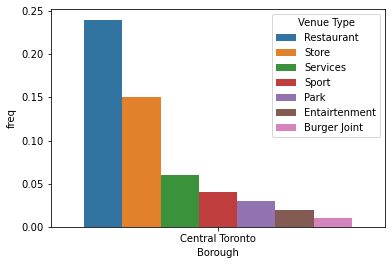

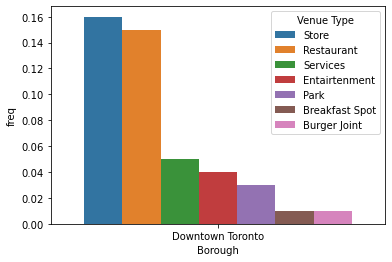

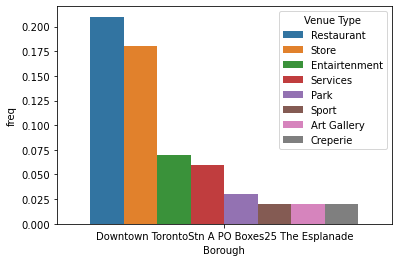

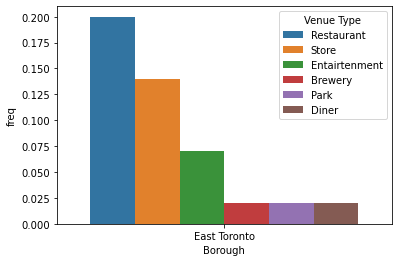

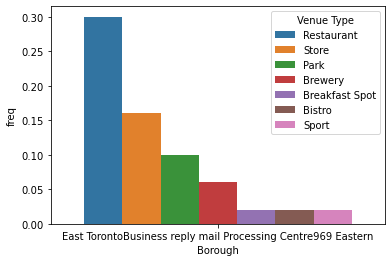

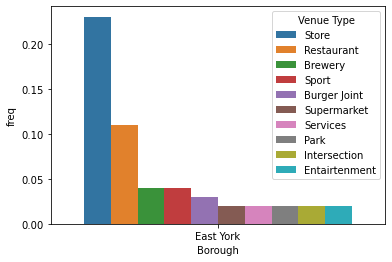

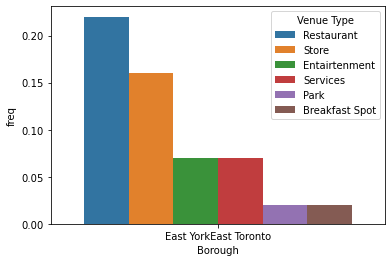

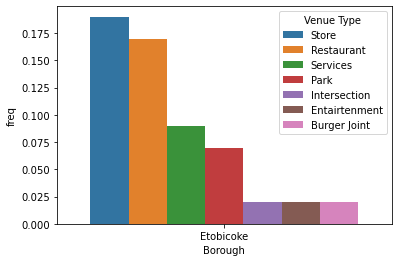

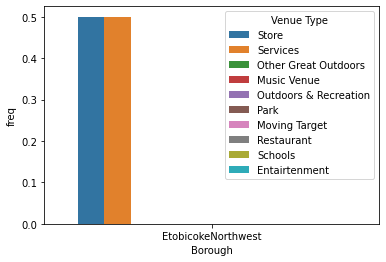

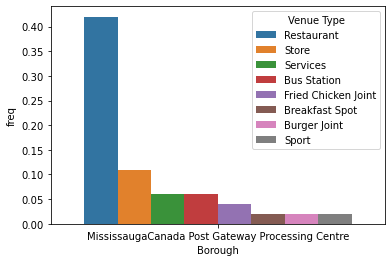

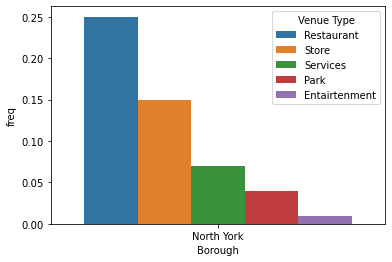

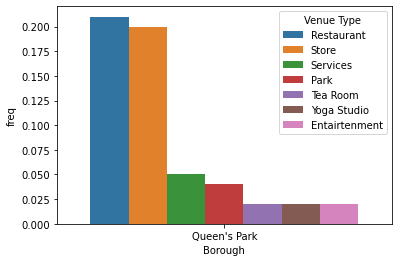

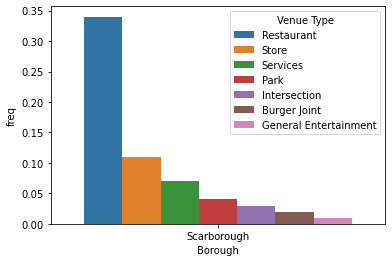

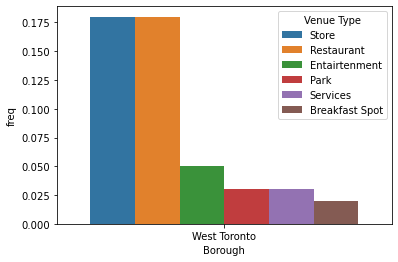

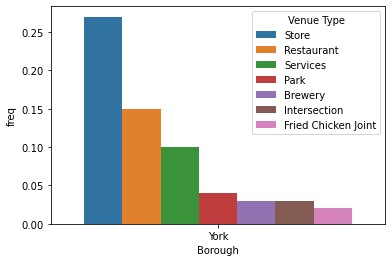

In [125]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

for item in np.unique(df_fre_aggregated['Borough']):
    df_bor =df_fre_aggregated[df_fre_aggregated['Borough']==item]
    plt.figure() #this creates a new figure on which your plot will appear
    sns.barplot(x='Borough',y='freq',hue='Venue Type',data=df_bor)


## We can point to 5 or 6 Borough where the frequency of Stores and Services facilities exceeds the freq of resaturant whihc is a good signe and shows a promising segmentation of Boroughs

1 - York

2- West Toronto

3-Etobicoke

4-East york 

5-Downtown toronto

In [139]:
york=toronto_onehot[toronto_onehot['Borough']=='York']

In [140]:
york_neighborhood = york.groupby('Neighborhood').mean().reset_index()


In [142]:
num_top_venues = 20
l=[]
for hood in york_neighborhood['Neighborhood']:
    print("----"+hood+"----")
    temp = york_neighborhood[york_neighborhood['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    temp['Neighborhood'] = hood
    temp=temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues)
    l.append(temp)
york_venue_neighborhood=pd.concat(l)

----Caledonia-Fairbanks----
----Del Ray, Mount Dennis, Keelsdale and Silverthorn----
----Humewood-Cedarvale----
----Runnymede, The Junction North----
----Weston----


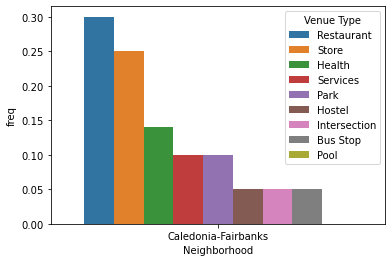

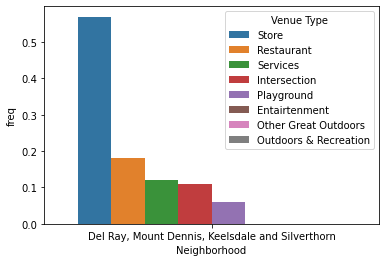

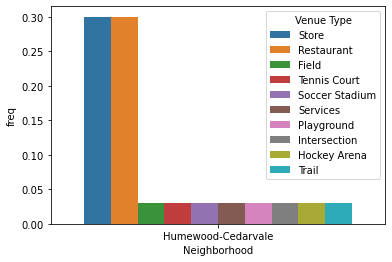

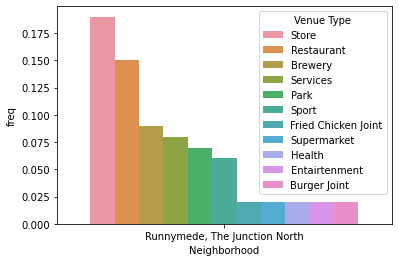

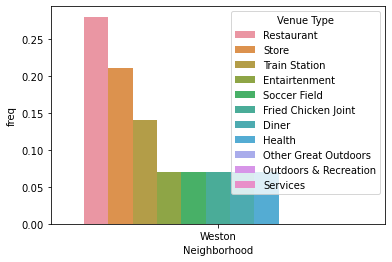

In [145]:
df_fre_test_york = york_venue_neighborhood
df_fre_test_york['venue'] = df_fre_test_york.venue.str.replace(r'(^.*Restaurant.*$)', 'Restaurant')
df_fre_test_york['venue'] = df_fre_test_york.venue.str.replace(r'(^.*Chicken*$)', 'Restaurant')
df_fre_test_york['venue'] = df_fre_test_york.venue.str.replace(r'(^.*Breakfast*$)', 'Restaurant')
df_fre_test_york['venue'] = df_fre_test_york.venue.str.replace(r'(^.*Noodle.*$)', 'Restaurant')
df_fre_test_york['venue'] = df_fre_test_york.venue.str.replace(r'(^.*Bakery.*$)', 'Restaurant')
df_fre_test_york['venue'] = df_fre_test_york.venue.str.replace(r'(^.*Place.*$)', 'Restaurant')
df_fre_test_york['venue'] = df_fre_test_york.venue.str.replace(r'(^.*Store.*$)', 'Store')
df_fre_test_york['venue'] = df_fre_test_york.venue.str.replace(r'(^.*Line.*$)', 'Services')
df_fre_test_york['venue'] = df_fre_test_york.venue.str.replace(r'(^.*Shop.*$)', 'Store')
df_fre_test_york['venue'] = df_fre_test_york.venue.str.replace(r'(^.*Grocery.*$)', 'Store')
df_fre_test_york['venue'] = df_fre_test_york.venue.str.replace(r'(^.*Market.*$)', 'Store')
df_fre_test_york['venue'] = df_fre_test_york.venue.str.replace(r'(^.*Café.*$)', 'Coffee Shop')
df_fre_test_york['venue'] = df_fre_test_york.venue.str.replace(r'(^.*Spa.*$)', 'Services')
df_fre_test_york['venue'] = df_fre_test_york.venue.str.replace(r'(^.*store.*$)', 'Store')
df_fre_test_york['venue'] = df_fre_test_york.venue.str.replace(r'(^.*Office.*$)', 'Services')
df_fre_test_york['venue'] = df_fre_test_york.venue.str.replace(r'(^.*Steak.*$)', 'Restaurant')
df_fre_test_york['venue'] = df_fre_test_york.venue.str.replace(r'(^.*Bar.*$)', 'Entairtenment')
df_fre_test_york['venue'] = df_fre_test_york.venue.str.replace(r'(^.*Skating.*$)', 'Entairtenment')
df_fre_test_york['venue'] = df_fre_test_york.venue.str.replace(r'(^.*Pharmacy.*$)', 'Health')
df_fre_test_york['venue'] = df_fre_test_york.venue.str.replace(r'(^.*School.*$)', 'Schools')
df_fre_test_york['venue'] = df_fre_test_york.venue.str.replace(r'(^.*Hospit.*$)', 'Health')
df_fre_test_york['venue'] = df_fre_test_york.venue.str.replace(r'(^.*Theater.*$)', 'Entairtenment')
df_fre_test_york['venue'] = df_fre_test_york.venue.str.replace(r'(^.*Beach.*$)', 'Entairtenment')
df_fre_test_york['venue'] = df_fre_test_york.venue.str.replace(r'(^.*Museum.*$)', 'Entairtenment')
df_fre_test_york['venue'] = df_fre_test_york.venue.str.replace(r'(^.*Pub.*$)', 'Entairtenment')
df_fre_test_york['venue'] = df_fre_test_york.venue.str.replace(r'(^.*Nightclub.*$)', 'Entairtenment')
df_fre_test_york['venue'] = df_fre_test_york.venue.str.replace(r'(^.*Bank.*$)', 'Services')
df_fre_test_york['venue'] = df_fre_test_york.venue.str.replace(r'(^.*Hotel.*$)', 'Services')
df_fre_test_york['venue'] = df_fre_test_york.venue.str.replace(r'(^.*Gas.*$)', 'Services')
df_fre_test_york['venue'] = df_fre_test_york.venue.str.replace(r'(^.*Nail Salon.*$)', 'Services')
df_fre_test_york['venue'] = df_fre_test_york.venue.str.replace(r'(^.*ATM.*$)', 'Services')
df_fre_test_york['venue'] = df_fre_test_york.venue.str.replace(r'(^.*Sport.*$)', 'Sport')
df_fre_test_york['venue'] = df_fre_test_york.venue.str.replace(r'(^.*Gym.*$)', 'Sport')


df_fre_test_york_ne= df_fre_test_york.groupby('Neighborhood')
l=[]
for name, group in df_fre_test_york_ne:
    group_by_venue = group.groupby('venue')
    for name1,group1 in group_by_venue:
        
        l.append([name,name1,group1['freq'].sum()])
df_fre_aggregated_ne = pd.DataFrame(l,columns=['Neighborhood','Venue Type','freq'])
df_fre_aggregated_ne = df_fre_aggregated_ne.sort_values('freq', ascending=False).reset_index(drop=True)
for item in np.unique(df_fre_aggregated_ne['Neighborhood']):
    df_bor =df_fre_aggregated_ne[df_fre_aggregated_ne['Neighborhood']==item]
    plt.figure() #this creates a new figure on which your plot will appear
    sns.barplot(x='Neighborhood',y='freq',hue='Venue Type',data=df_bor)


## Conclusion

## We can point to 5 or 6 Boroughs in toronto where the frequency of Stores and Services facilities exceeds the freq of resaturant whihc is a good signe and shows a promising segmentation of Boroughs

1 - York

2- West Toronto

3-Etobicoke

4-East york 

5-Downtown toronto

## Given the example of York Borough, one of the best neighborhood to start a restaurant business is :
    
    1 - The Junction north
    2 - Humewood
    3 - Mount dennis
